## Import the package and data

In [4]:
import numpy as np
import pandas as pd
import math
import torch
import matplotlib.pyplot  as plt
import matplotlib
import copy
from lifelines import CoxPHFitter

from random import shuffle
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset,ConcatDataset
from torch import nn
from torchvision import datasets,transforms
from scipy.stats import chi2
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import Axes3D
from DML_COX import *
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
def ToTensor(data):
    return torch.tensor(np.array(data)).to(torch.float32)

def numPercent(data):
    for col in data.columns:
        num = data[col].isna().sum() # nan个数
        print(col,num / len(data)) # 占比

def impute_NA(data,print_state=False):
    data=data.astype(np.float32)
    subset_na = np.isnan(data)
    if print_state:
        print(np.median(data[~subset_na]))
    data[subset_na] = np.median(data[~subset_na])
    return data


In [6]:
# read colon.csv
colon = pd.read_csv('colon.csv')
colon_rec = colon.iloc[range(1,len(colon),2)]
colon_death = colon.iloc[range(0,len(colon),2)]

data = colon_rec
# print(data.head())
T = ToTensor(data.time).unsqueeze(1)
D = ToTensor(data.status).unsqueeze(1)
X = ToTensor(pd.get_dummies(data.rx))[:,0:2]
print(data.rx)
print(X)

1       Lev+5FU
3       Lev+5FU
5           Obs
7       Lev+5FU
9           Obs
         ...   
1849    Lev+5FU
1851        Lev
1853        Lev
1855    Lev+5FU
1857        Lev
Name: rx, Length: 929, dtype: object
tensor([[0., 1.],
        [0., 1.],
        [0., 0.],
        ...,
        [1., 0.],
        [0., 1.],
        [1., 0.]])


In [7]:
sex = ToTensor(data.sex).unsqueeze(1)
age = ToTensor(data.age).unsqueeze(1)
obstruct = ToTensor(data.obstruct).unsqueeze(1)
perfor = ToTensor(data.perfor).unsqueeze(1)
adhere = ToTensor(data.adhere).unsqueeze(1)
nodes = (ToTensor(impute_NA(data.nodes,print_state=True))).unsqueeze(1)
differ = (ToTensor(pd.get_dummies(impute_NA(data.differ,print_state=True))))[:,1:3]
extent = (ToTensor(pd.get_dummies(data.extent)))[:,1:4]
surg = (ToTensor(data.surg)).unsqueeze(1)
node4 = (ToTensor(data.node4)).unsqueeze(1)

Z=feature_normalize(torch.cat((sex,age,obstruct,perfor,adhere,nodes,differ,extent,surg,node4),axis=1))
mydat = DeepSurvData(T,D,X,Z,device)
print(mydat.Z.shape)

2.0
2.0
torch.Size([929, 13])


## Estimating $\theta(Z)$, $\Lambda(t)$ by Partial linear Cox methods

In [8]:
# np.random.seed(2024)
sample=np.random.permutation(np.arange(len(mydat.T)))
sample1 = sample[0:800]
sample2 = sample[800:len(sample)]
mydat_train = mydat[sample1] 
mydat_test = mydat[sample2]
print(mydat_train.Z.shape)

torch.Size([800, 13])


In [9]:
model_theta = nn.Sequential(
    nn.Linear(mydat.Z.shape[1],100),
    nn.ReLU(),
    nn.Linear(100,1),
)

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(mydat.Z.shape[1],50),
    nn.ReLU(),
    nn.Linear(50,mydat.X.shape[1]),
    nn.Sigmoid(),
)


Epoch_XZ=181
lr_XZ=5e-4
Epoch_theta=181
lr_theta=5e-4


beta_est,theta_est = fit_CoxPH(mydat_train,device=device,model=model_theta,
                               Epoch=Epoch_theta, lr=lr_theta,
                               Test_set=mydat_test,print_state=True)
print(beta_est)

# T_interval = torch.quantile(mydat.T,torch.arange(0,0.9,0.2).to(device))
# print('train E[X|Z,T>t]')
# model_XZ = fit_XZ_complete(mydat_train,T_interval=T_interval,device=device,loss_fn=nn.BCELoss(),
#                            model=model_XZ, lr=lr_XZ, Epoch=Epoch_XZ,
#                            Test_set=mydat_test,print_state=True)


epoch: 0 Train_loss:3.17304, epoch: 0 Test_loss:2.52306
epoch: 10 Train_loss:3.15215, epoch: 10 Test_loss:2.50116
epoch: 20 Train_loss:3.13552, epoch: 20 Test_loss:2.48346
epoch: 30 Train_loss:3.12264, epoch: 30 Test_loss:2.46950
epoch: 40 Train_loss:3.11285, epoch: 40 Test_loss:2.45930
epoch: 50 Train_loss:3.10546, epoch: 50 Test_loss:2.45234
epoch: 60 Train_loss:3.09959, epoch: 60 Test_loss:2.44800
epoch: 70 Train_loss:3.09452, epoch: 70 Test_loss:2.44548
epoch: 80 Train_loss:3.08977, epoch: 80 Test_loss:2.44401
epoch: 90 Train_loss:3.08522, epoch: 90 Test_loss:2.44311
epoch: 100 Train_loss:3.08073, epoch: 100 Test_loss:2.44238
epoch: 110 Train_loss:3.07630, epoch: 110 Test_loss:2.44189
epoch: 120 Train_loss:3.07194, epoch: 120 Test_loss:2.44154
epoch: 130 Train_loss:3.06747, epoch: 130 Test_loss:2.44119
epoch: 140 Train_loss:3.06293, epoch: 140 Test_loss:2.44085
epoch: 150 Train_loss:3.05839, epoch: 150 Test_loss:2.44112
tensor([-0.0249, -0.1526], device='cuda:0')


## Double Robust Estimation

In [10]:
model_theta = nn.Sequential(
    nn.Linear(mydat.Z.shape[1],50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50,1),
)

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(mydat.Z.shape[1],50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50,mydat.X.shape[1]),
    nn.Sigmoid(),
)

# model_theta = nn.Sequential(
#     nn.Linear(mydat.Z.shape[1],100),
#     nn.Sigmoid(),
#     nn.Linear(100,1),
# )

# # define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
# model_XZ = nn.Sequential(
#     nn.Linear(mydat.Z.shape[1],50),
#     nn.Sigmoid(),
#     nn.Linear(50,mydat.X.shape[1]),
#     nn.Sigmoid(),
# )

Epoch_XZ=181
lr_XZ=3e-4
Epoch_theta=181
lr_theta=5e-4
accuracy=0.1

In [11]:
np.random.seed(2024);torch.manual_seed(2024)
sample=np.random.permutation(np.arange(len(mydat.T)))
sample1 = sample[0:800]
sample2 = sample[800:len(sample)]
mydat_train = mydat[sample1] 
mydat_test = mydat[sample2]


# train the double robust model
(beta_DB, var_est_DB, 
 beta_est1, deepSurv1,  model_XZ1, 
 beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(mydat_train, device=device,accuracy=accuracy, Test_set= mydat_test,
                                              model_XZ=model_XZ, model_theta=model_theta,
                                              Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
                                              lr_XZ=lr_XZ, lr_theta=lr_theta,
                                              print_state=True)

beta_naive=(beta_est1+beta_est2)/2
net = CustomNet(h_dims=[1, 50,50,50, 2], g_dims=[13,50,50,50, 2])
var_est_naive = fit_variance(mydat_train, net, device=device, lr=4e-5,Epoch=400,print_state=False)

# (beta_DB, var_est, 
#  beta_est1, deepSurv1,  model_XZ1, 
#  beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(mydat, device=device,accuracy=accuracy, Test_set= False,
#                                               model_XZ=model_XZ, model_theta=model_theta,
#                                               Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
#                                               lr_XZ=lr_XZ, lr_theta=lr_theta,
#                                               print_state=True)



# # calculate the direct parameter estimator without using double robust techniques

# # calculate the p_value
# beta=torch.zeros(2).to(device)
# chi_value = torch.squeeze((beta_DB-beta) @ torch.inverse(var_est) @ torch.unsqueeze(beta_DB-beta,1))
# p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_DB))
# p_value_single = 1 - chi2.cdf(((beta_DB-beta)**2/torch.diag(var_est)).cpu(),1)
# print()
# print('直接估计偏差：',beta_naive-beta,'偏差模长：',torch.norm(beta_naive-beta))
# print('双重鲁棒估计偏差：',beta_DB-beta,'偏差模长：',torch.norm(beta_DB-beta))
# print('双重鲁棒估计标准差：',torch.sqrt(torch.diag(var_est)))
# print('双重鲁棒估计检验 H_0: β=β_0, p值：%.5f'%p_value_joint)
# for i in range(len(beta_DB)):
#     print('双重鲁棒估计检验 H_0: β[%d]=β_0[%d], p值：%.5f'%(i,i,p_value_single[i]))

train theta(Z)
epoch: 0 Train_loss:3.25422, epoch: 0 Test_loss:2.21850
epoch: 10 Train_loss:3.23612, epoch: 10 Test_loss:2.20876
epoch: 20 Train_loss:3.21956, epoch: 20 Test_loss:2.20163
epoch: 30 Train_loss:3.20364, epoch: 30 Test_loss:2.19701
epoch: 40 Train_loss:3.18887, epoch: 40 Test_loss:2.19481
epoch: 50 Train_loss:3.17621, epoch: 50 Test_loss:2.19391
epoch: 60 Train_loss:3.16680, epoch: 60 Test_loss:2.19344
epoch: 70 Train_loss:3.16023, epoch: 70 Test_loss:2.19245
epoch: 80 Train_loss:3.15412, epoch: 80 Test_loss:2.18983
epoch: 90 Train_loss:3.14800, epoch: 90 Test_loss:2.18833
epoch: 100 Train_loss:3.14195, epoch: 100 Test_loss:2.18801
epoch: 110 Train_loss:3.13591, epoch: 110 Test_loss:2.18899
train E[X|Z,T>t]
epoch: 0 Train_loss:2.26282, epoch: 0 Test_loss:2.22852
epoch: 10 Train_loss:2.21404, epoch: 10 Test_loss:2.17845
epoch: 20 Train_loss:2.16959, epoch: 20 Test_loss:2.13452
epoch: 30 Train_loss:2.12939, epoch: 30 Test_loss:2.09533
epoch: 40 Train_loss:2.09377, epoch: 40 

In [12]:
# var_est_naive=var_est_naive.to(device)
print()
beta=torch.zeros(2).to(device)
chi_value = torch.squeeze((beta_naive-beta) @ torch.inverse(var_est_naive) @ torch.unsqueeze(beta_naive-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_naive))
p_value_single = 1 - chi2.cdf(((beta_naive-beta)**2/torch.diag(var_est_naive)).cpu(),1)
print('PL Cox bias：',beta_naive-beta,'bias norm:',torch.norm(beta_naive-beta))
print('PL Cox standard error：',torch.sqrt(torch.diag(var_est_naive)))
print('PL Cox test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_naive)):
    print('PL Cox test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


print()
chi_value = torch.squeeze((beta_DB-beta) @ torch.inverse(var_est_DB) @ torch.unsqueeze(beta_DB-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_DB))
p_value_single = 1 - chi2.cdf(((beta_DB-beta)**2/torch.diag(var_est_DB)).cpu(),1)
print('DBPL bias：',beta_DB-beta,'DBPL bias：',torch.norm(beta_DB-beta))
print('DBPL standard error：',torch.sqrt(torch.diag(var_est_DB)))
print('DBPL test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_DB)):
    print('DBPL test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


PL Cox bias： tensor([ 0.1153, -0.2264], device='cuda:0') bias norm: tensor(0.2541, device='cuda:0')
PL Cox standard error： tensor([0.1155, 0.1277], device='cuda:0')
PL Cox test H_0: β=β_0, p value：0.02989
PL Cox test H_0: β[0]=β_0[0], p value：0.31821
PL Cox test H_0: β[1]=β_0[1], p value：0.07623

DBPL bias： tensor([-0.0547, -0.4600], device='cuda:0') DBPL bias： tensor(0.4632, device='cuda:0')
DBPL standard error： tensor([0.1217, 0.1334], device='cuda:0')
DBPL test H_0: β=β_0, p value：0.00075
DBPL test H_0: β[0]=β_0[0], p value：0.65286
DBPL test H_0: β[1]=β_0[1], p value：0.00057


## Cross validation

In [13]:
def toPandas(data):
    return  pd.DataFrame(torch.cat([data.T.cpu(), data.D.cpu(),data.X.cpu(),data.Z.cpu()],1))  

np.random.seed(2024); torch.manual_seed(1)

model_theta = nn.Sequential(
    nn.Linear(mydat.Z.shape[1],50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50,1),
)

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(mydat.Z.shape[1],50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50,mydat.X.shape[1]),
    nn.Sigmoid(),
)

# model_theta = nn.Sequential(
#     nn.Linear(mydat.Z.shape[1],100),
#     nn.Sigmoid(),
#     nn.Linear(100,1),
# )

# # define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
# model_XZ = nn.Sequential(
#     nn.Linear(mydat.Z.shape[1],50),
#     nn.Sigmoid(),
#     nn.Linear(50,mydat.X.shape[1]),
#     nn.Sigmoid(),
# )

Epoch_XZ=181
lr_XZ=3e-4
Epoch_theta=181
lr_theta=1e-3
accuracy=0.1

In [14]:
np.random.seed(2024); torch.manual_seed(1)
BETA_DB = list()
BETA_NAIVE = list()
BETA_COX = list()

SE_DB = list()
SE_NAIVE = list()
SE_COX = list()

np.random.seed(2024)
sample = np.random.permutation(np.arange(len(mydat.T)))
# Split the vector into 5 random parts
split_vector = np.array_split(sample, 5)
# Print the resulting split vector
for i, sample_val in enumerate(split_vector):
    mask = np.isin(sample, sample_val, invert=True)
    mydat_train = mydat[sample[mask]] 
    mydat_test = mydat[sample_val]
    
    # train the double robust model
    (beta_DB, var_est_DB, 
     beta_est1, deepSurv1,  model_XZ1, 
     beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(mydat_train, device=device,accuracy=accuracy, Test_set= mydat_test,
                                                  model_XZ=model_XZ, model_theta=model_theta,
                                                  Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
                                                  lr_XZ=lr_XZ, lr_theta=lr_theta,
                                                  print_state=False)

    beta=torch.zeros(2)
    beta_naive=(beta_est1+beta_est2)/2
    net = CustomNet(h_dims=[1, 50,50,50, len(beta)], g_dims=[13,50,50,50, len(beta)])
    var_est_naive = fit_variance(mydat_train, net, device=device, lr=4e-5,Epoch=400,print_state=False)
    
    cph = CoxPHFitter()
    cph.fit(toPandas(mydat_train), 0, 1)
    # cph.print_summary()
    beta_Cox = np.array(cph.params_[0:2])
    se_Cox = np.sqrt(np.diag(cph.variance_matrix_)[0:2])

    BETA_DB.append(beta_DB.cpu())
    BETA_NAIVE.append(beta_naive.cpu())
    BETA_COX.append(beta_Cox)
    SE_COX.append(se_Cox)
    SE_NAIVE.append(np.sqrt(np.diag(var_est_naive.cpu())))
    SE_DB.append(np.sqrt(np.diag(var_est_DB.cpu())))

    print(i,end=' ')
    pass



0 1 2 3 4 

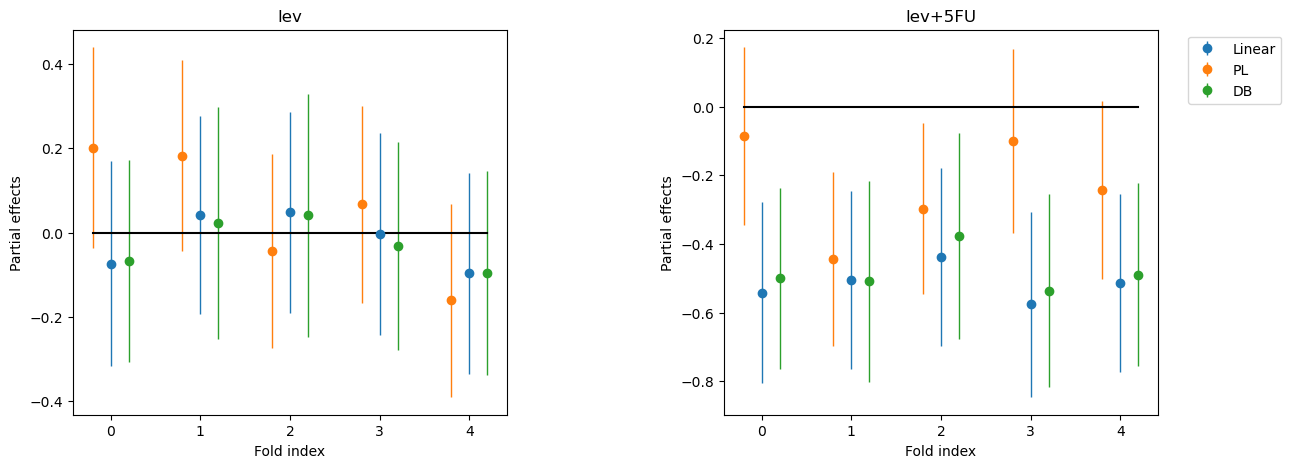

In [16]:
plt.figure(figsize=[14,5])
plt.subplot(1,2,1)
plt.errorbar(range(5), np.array(BETA_COX)[:,0],1.96*np.array(SE_COX)[:,0],fmt='o', linewidth=1)
plt.errorbar(np.arange(5)-0.2, np.array(BETA_NAIVE)[:,0],1.96*np.array(SE_NAIVE)[:,0],fmt='o', linewidth=1)
plt.errorbar(np.arange(5)+0.2, np.array(BETA_DB)[:,0],1.96*np.array(SE_DB)[:,0],fmt='o', linewidth=1)
plt.plot([-0.2,4.2],[0,0],color='black')
plt.xlabel('Fold index')
plt.ylabel('Partial effects')
plt.title('lev')

plt.subplot(1,2,2)
plt.errorbar(range(5), np.array(BETA_COX)[:,1],1.96*np.array(SE_COX)[:,1],fmt='o',label='Linear', linewidth=1)
plt.errorbar(np.arange(5)-0.2, np.array(BETA_NAIVE)[:,1],1.96*np.array(SE_NAIVE)[:,1],fmt='o',label='PL', linewidth=1)
plt.errorbar(np.arange(5)+0.2, np.array(BETA_DB)[:,1],1.96*np.array(SE_DB)[:,1],fmt='o',label='DB', linewidth=1)
plt.plot([-0.2,4.2],[0,0],color='black')
plt.xlabel('Fold index')
plt.ylabel('Partial effects')
# plt.ylim(-0.6,1)
plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1))

plt.title('lev+5FU')

plt.subplots_adjust(wspace=0.5)
plt.savefig('colon_death.pdf')
plt.show()